row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64
row_hash             1905
timestamp            1905
date                 1905
dtc_code             1905
p_raw_precursor      1905
p_calib_precursor    1905
p_raw_fault          1905
p_calib_fault        1905
dPdt_precursor       1905
dPdt_fault           1905
pred_precursor_on    1905
pred_fault_on        1905
alert_level          1905
feature_snapshot     1905
dtype: int64
row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault  

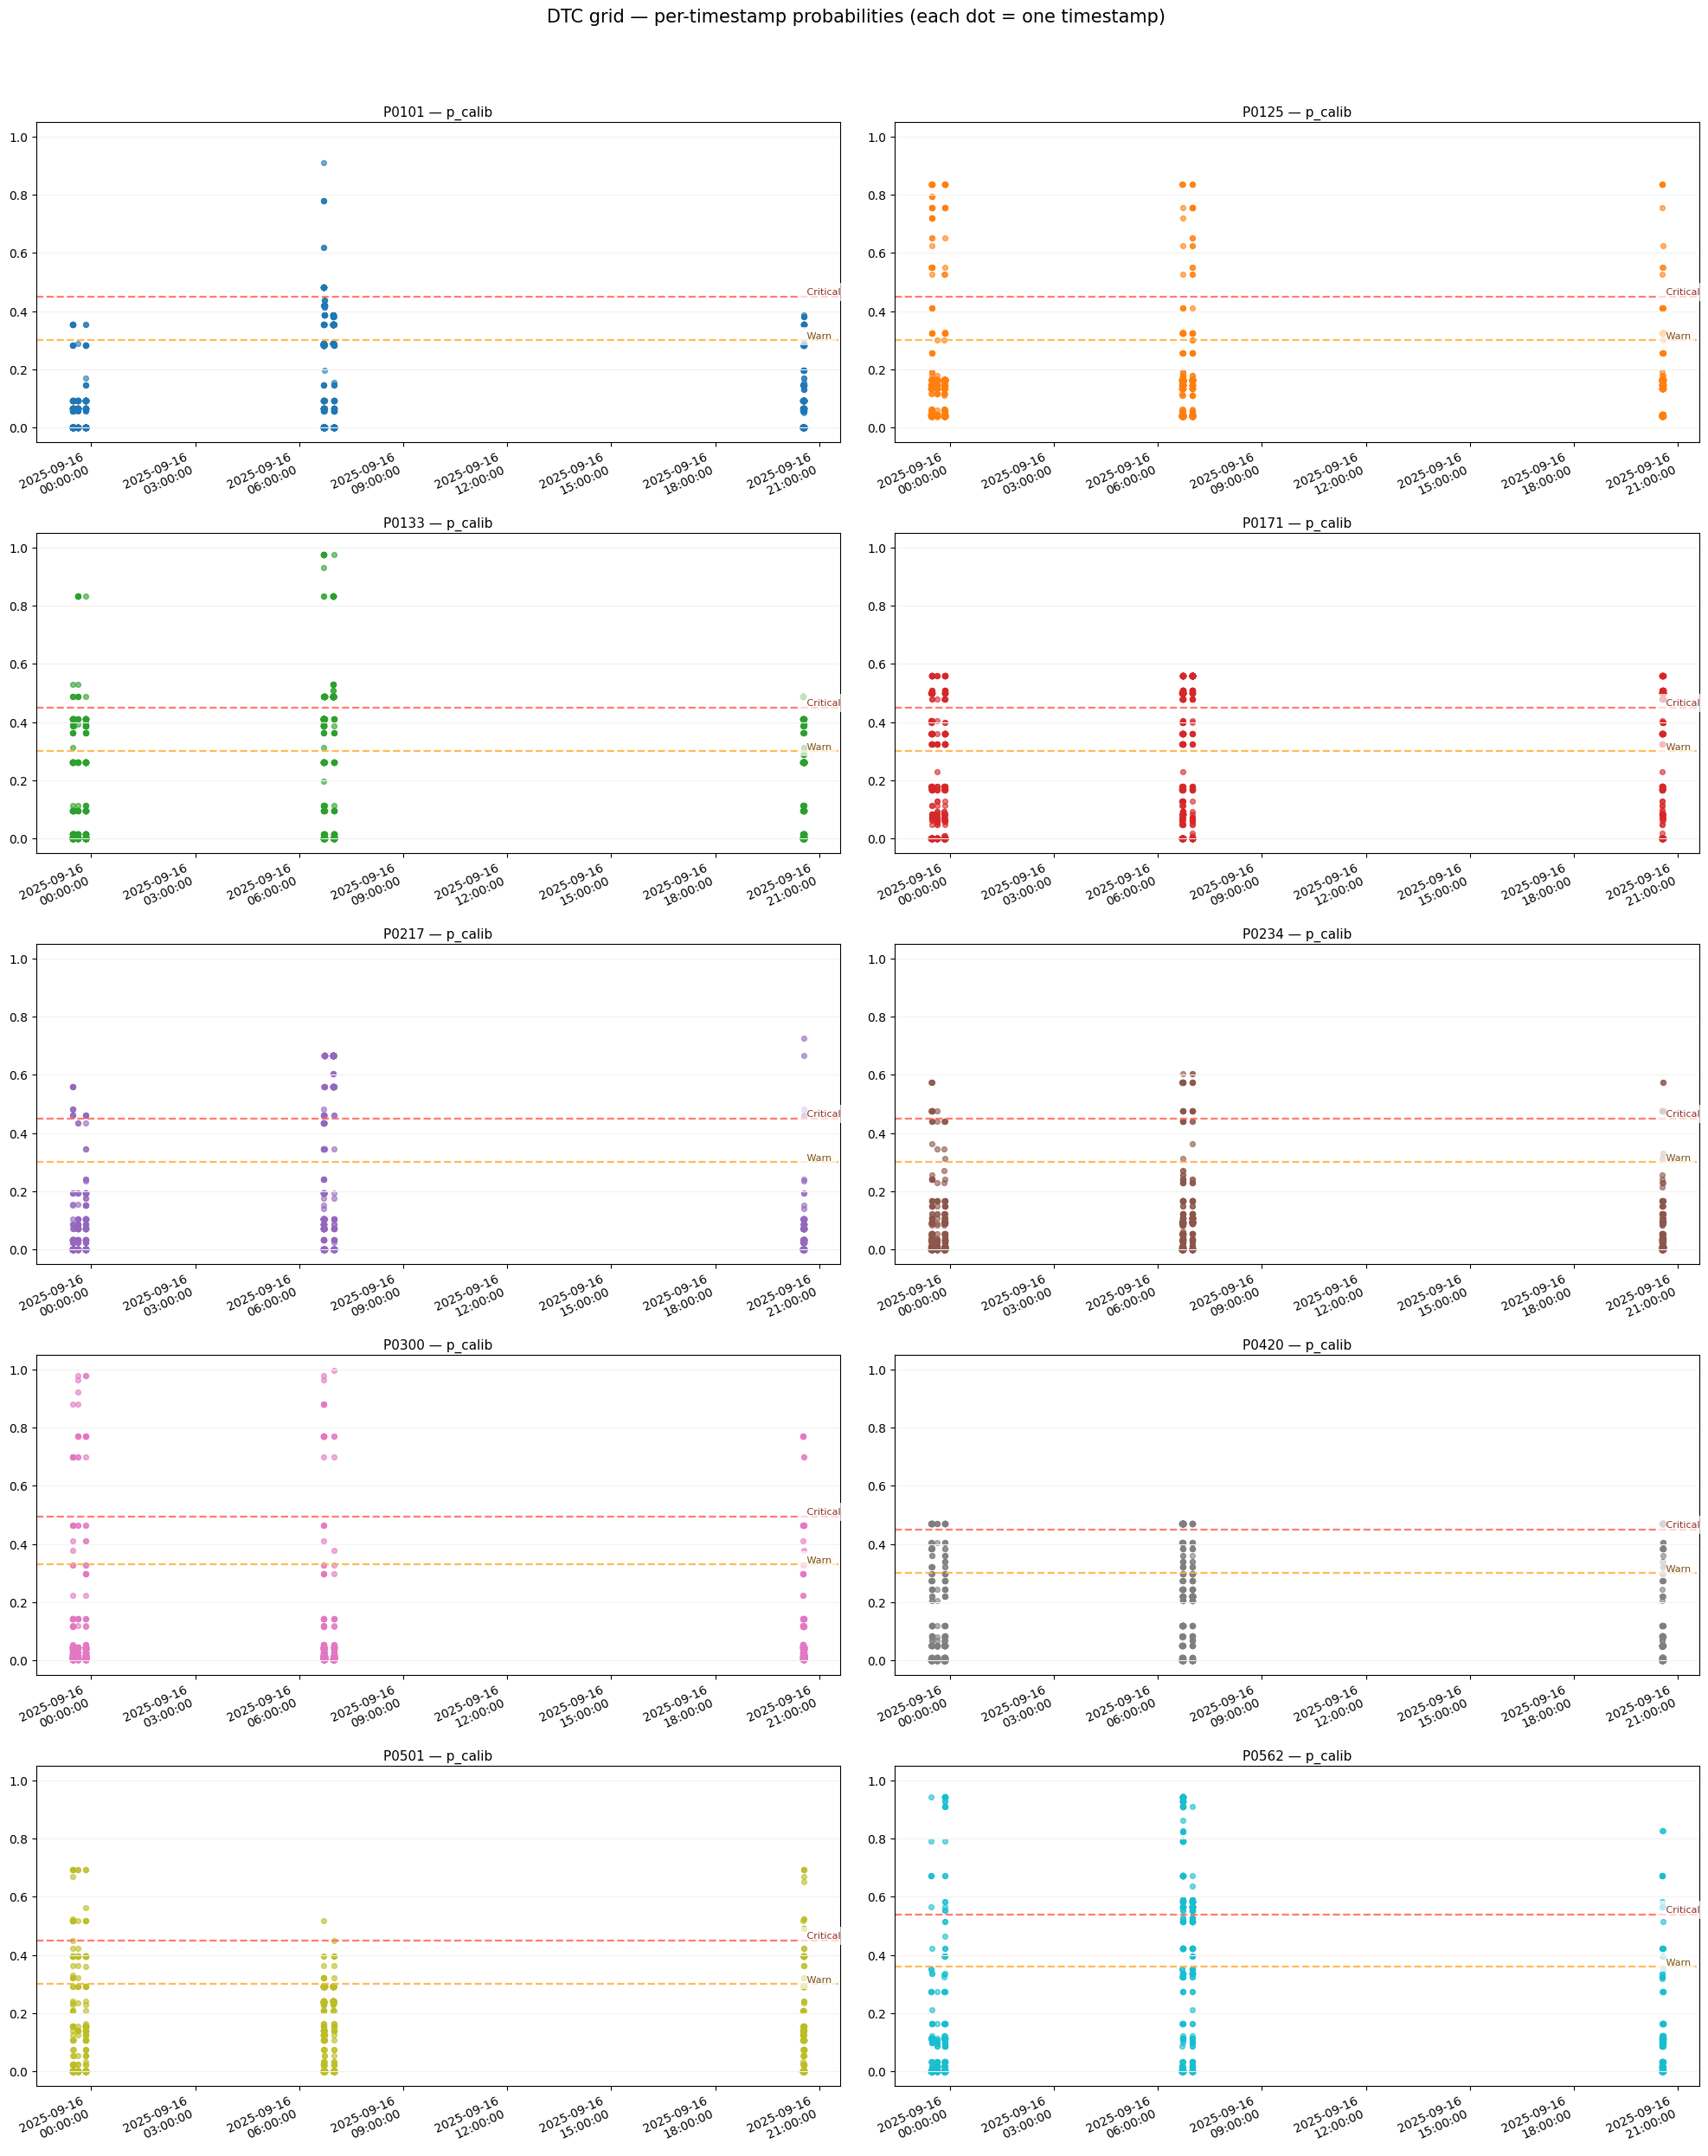

In [1]:
import json
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


ROOT = Path(r"C:\engine_module_pipeline")
CSV_DIR = ROOT / r"DTC_stage\data\csv"
ARTIFACTS_ROOT = ROOT / r"DTC_stage\artifacts"

MAX_PLOTS = 11
N_COLS = 2                 # grid columns
FIG_W = 20                 # wider canvas for time axis
FIG_H_PER_ROW = 5        # taller subplots
DOT_SIZE = 18              # marker size
ALPHA_DOT = 0.6            # transparency
GRID_COLOR = "#f2f2f2"
DATE_FMT = mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S")

PROB_PRIOR = [
    "p_calib_precursor",
    "p_calib_fault",
    "p_raw_precursor",
    "p_raw_fault",
]

def load_thresholds_for_dtc(dtc_code: str):
    thr_path = ARTIFACTS_ROOT / dtc_code / "thresholds.json"
    warn, crit = 0.6, 0.85
    if thr_path.exists():
        try:
            thr = json.load(open(thr_path, "r"))
            warn = float(thr.get("cumulative_warn", thr.get("prec_on", 0.75) * 0.6))
            crit = float(thr.get("cumulative_crit", thr.get("prec_on", 0.75) * 0.9))
            warn = max(0.0, min(1.0, warn))
            crit = max(warn + 1e-6, min(1.0, crit))
        except Exception:
            pass
    return warn, crit

def choose_probability_column(df: pd.DataFrame):
    for c in PROB_PRIOR:
        if c in df.columns:
            return c
    p_cols = [c for c in df.columns if c.startswith("p_") and pd.api.types.is_numeric_dtype(df[c])]
    return p_cols[0] if p_cols else None

def load_dtc_df(dtc_code: str) -> pd.DataFrame:
    path = CSV_DIR / f"{dtc_code}_infer_output.csv"
    if not path.exists():
        raise FileNotFoundError(f"CSV not found for DTC {dtc_code}")
    df = pd.read_csv(path, dtype=str)
    print(df.count())
    if "timestamp" not in df.columns:
        raise RuntimeError(f"{path} missing 'timestamp'")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    for col in df.columns:
        if col not in ["timestamp","date","row_hash","dtc_code","feature_snapshot"]:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            except Exception:
                pass
    return df

def plot_dtc_grid_dots(dtc_codes: List[str], max_plots: int = MAX_PLOTS, n_cols: int = N_COLS):
    dtc_codes = dtc_codes[:max_plots]
    n = len(dtc_codes)
    n_cols = min(n_cols, n)
    n_rows = (n + n_cols - 1) // n_cols

    fig_h = max(3, FIG_H_PER_ROW * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(FIG_W, fig_h), squeeze=False)
    axes_flat = axes.flatten()

    for ax in axes_flat[n:]:
        ax.set_visible(False)

    cmap = plt.get_cmap("tab10")

    for i, dtc in enumerate(dtc_codes):
        ax = axes_flat[i]
        try:
            df = load_dtc_df(dtc)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading {dtc}:\n{e}", ha="center", va="center", color="red")
            ax.set_axis_off()
            continue

        chosen = choose_probability_column(df)
        if "p_calib_precursor" in df.columns and "p_calib_fault" in df.columns:
            df["p_calib"] = df[["p_calib_precursor"]].max(axis=1)
            chosen = "p_calib"

        if chosen is None:
            ax.text(0.5, 0.5, f"No prob col for {dtc}", ha="center", va="center")
            ax.set_axis_off()
            continue

        y = df[chosen].astype(float).fillna(0.0)
        x = df["timestamp"]
        color = cmap(i % 10)

        ax.scatter(x, y, s=DOT_SIZE, color=color, alpha=ALPHA_DOT)

        try:
            warn, crit = load_thresholds_for_dtc(dtc)
            ax.axhline(warn, color="#ffb347", linestyle="--", linewidth=1.6, alpha=0.9)
            ax.axhline(crit, color="#ff6f61", linestyle="--", linewidth=1.6, alpha=0.9)
            x_right = x.max()
            ax.text(x_right, warn, " Warn", va="bottom", ha="left", fontsize=8, color="#7a4d12",
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor='none'))
            ax.text(x_right, crit, " Critical", va="bottom", ha="left", fontsize=8, color="#8e2f23",
                    bbox=dict(facecolor="white", alpha=0.7, edgecolor='none'))
        except Exception:
            pass

        ax.set_title(f"{dtc} — {chosen}", fontsize=11, pad=5)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(axis="y", color=GRID_COLOR)
        ax.xaxis.set_major_formatter(DATE_FMT)
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(25)
            lbl.set_ha("right")

    plt.suptitle("DTC grid — per-timestamp probabilities (each dot = one timestamp)", fontsize=15, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_dtc_grid_dots(["P0101","P0125","P0133","P0171","P0217","P0234", "P0300", "P0420", "P0501", "P0562"])  # ["P0101","P0125","P0133","P0171","P0217"]


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path(r"C:\engine_module_pipeline")
CSV_DIR = ROOT / r"DTC_stage\data\csv"

def _load_dtc_csv(dtc_code: str) -> pd.DataFrame:
    path = CSV_DIR / f"{dtc_code}_infer_output.csv"
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    df = pd.read_csv(path, dtype=str)
    if "timestamp" not in df.columns:
        raise RuntimeError("CSV missing 'timestamp' column")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    for c in df.columns:
        if c not in ["timestamp","date","row_hash","dtc_code","feature_snapshot"]:
            try:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            except Exception:
                pass
    return df

def _choose_prob_col(df: pd.DataFrame) -> str:
    preferred = ("p_calib_precursor","p_calib_fault","p_raw_precursor","p_raw_fault")
    for c in preferred:
        if c in df.columns:
            return c
    pcols = [c for c in df.columns if c.startswith("p_") and pd.api.types.is_numeric_dtype(df[c])]
    if not pcols:
        raise RuntimeError("No probability columns found")
    return pcols[0]

def _resample_interpolate(df: pd.DataFrame, col: str, freq: str = "1S") -> pd.DataFrame:
    tmp = df[["timestamp", col]].dropna().sort_values("timestamp").copy()
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce").fillna(0.0).clip(0.0, 1.0)
    ts = tmp.set_index("timestamp")
    if ts.index.has_duplicates:
        ts = ts.groupby(level=0).mean()
    ts = ts.resample(freq).mean()
    ts[col] = (
        ts[col]
        .interpolate(method="time", limit_area="inside")
        .bfill()
        .ffill()
        .clip(0.0, 1.0)
    )
    return ts.reset_index()

def _dynamic_thresholds(series: pd.Series, q_warn: float = 0.80, q_crit: float = 0.95) -> tuple[float,float]:
    s = series.replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return 0.6, 0.85
    warn = float(s.quantile(q_warn))
    crit = float(s.quantile(q_crit))
    if crit <= warn:
        crit = min(1.0, warn + 0.05)  # guard
    return warn, crit

def plot_cumulative_build_up_with_chance(
    dtc_code: str,
    value_col: str | None = None,
    resample_freq: str = "1S",
    q_warn: float = 0.80,
    q_crit: float = 0.95,
    figsize: tuple[int,int] = (12, 5),
    line_width: float = 2.0,
):
    df = _load_dtc_csv(dtc_code)
    if value_col is None:
        value_col = _choose_prob_col(df)

    dfr = _resample_interpolate(df, value_col, freq=resample_freq)
    p = dfr[value_col].clip(0, 1)
    cum_raw = p.cumsum()
    max_cum = float(cum_raw.max()) if len(cum_raw) else 0.0
    cum_norm = (cum_raw / max_cum) if max_cum > 0 else pd.Series(np.zeros_like(cum_raw), index=cum_raw.index)

    warn, crit = _dynamic_thresholds(cum_norm, q_warn=q_warn, q_crit=q_crit)

    denom = max(crit - warn, 1e-9)
    chance = ((cum_norm - warn) / denom).clip(0.0, 1.0)

    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    ax.plot(dfr["timestamp"], cum_norm, label="Cumulative build-up (norm)", linewidth=line_width, color="#1f77b4")
    ax.plot(dfr["timestamp"], chance,   label="Chance to hit",            linewidth=line_width, color="#d62728")

    ax.axhline(y=warn, color="#ffb43c", linewidth=2.2)
    ax.axhline(y=crit, color="#ff6e50", linewidth=2.2)

    x_right = dfr["timestamp"].iloc[-1] if not dfr.empty else None
    if x_right is not None:
        ax.text(x_right, warn, "  Warn ", va="bottom", ha="left", fontsize=10, color="#a86f27")
        ax.text(x_right, crit, "  Critical", va="bottom", ha="left", fontsize=10, color="#a83b2b")

    ax.set_title(f"{dtc_code} — Cumulative build-up (normalized) + Chance-to-Hit\n, thresholds from cumulative)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Value (0..1)")
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.12)
    ax.legend(loc="upper left")

    plt.show()

# plot_cumulative_build_up_with_chance(
#     dtc_code="P0125",
#     value_col="p_calib_precursor",   
#     resample_freq="1S",
#     q_warn=0.60,
#     q_crit=0.75,
#     figsize=(12,5)
# )



=== Generating plots for P0101 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


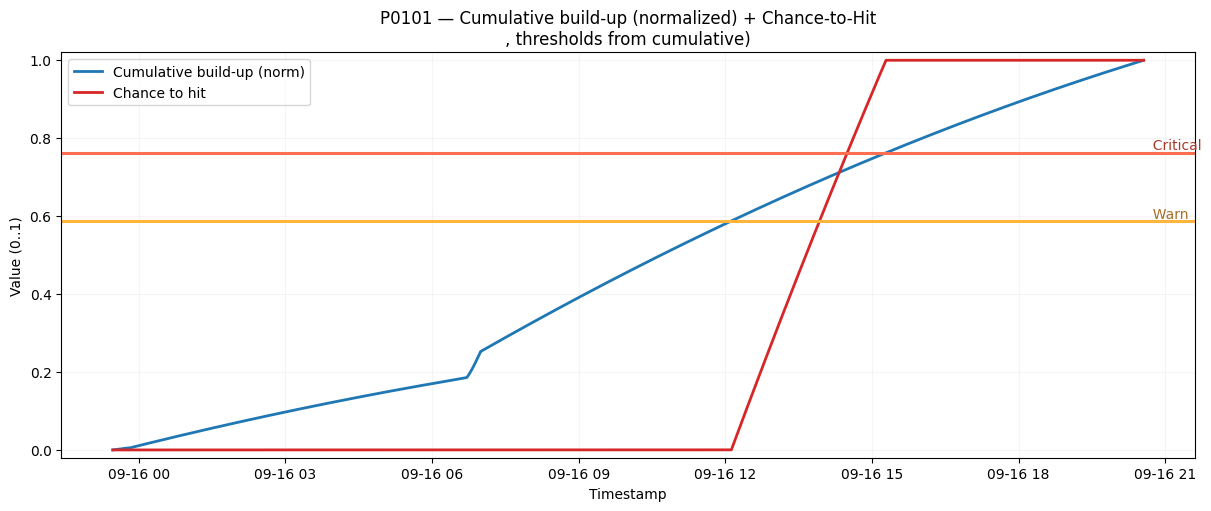


=== Generating plots for P0125 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


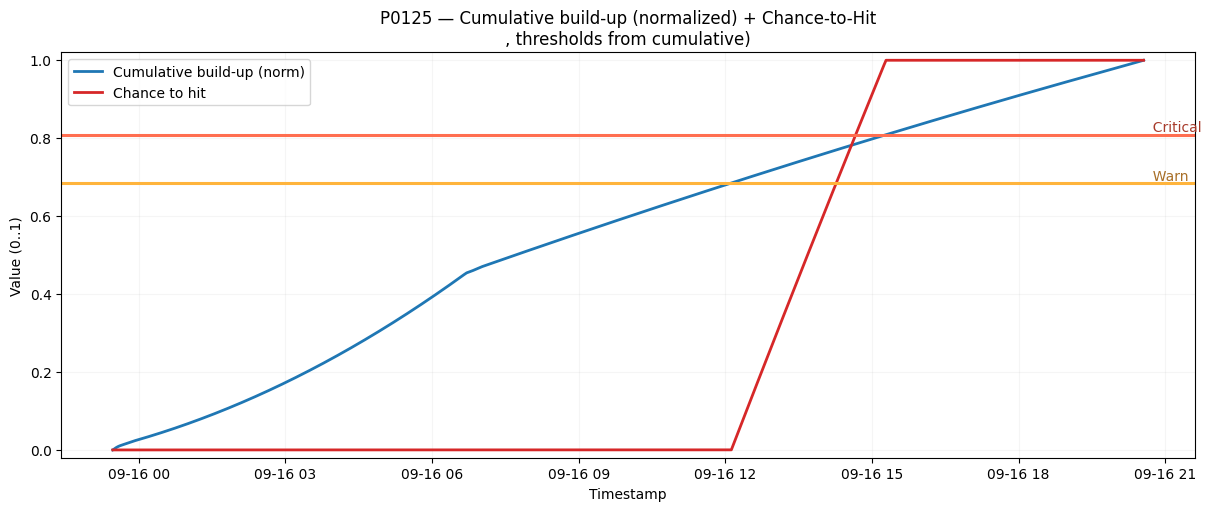


=== Generating plots for P0133 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


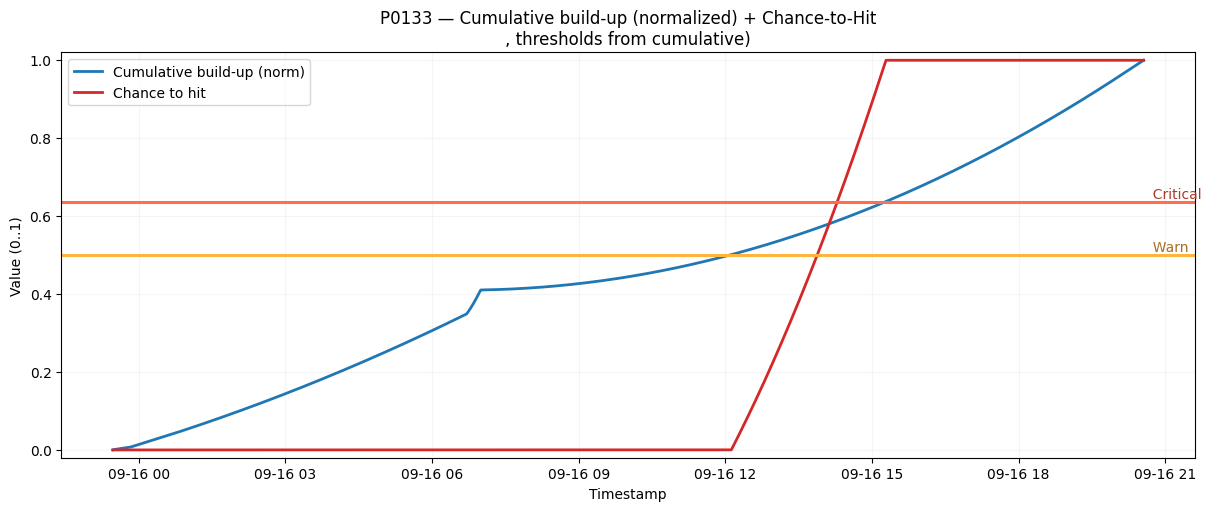


=== Generating plots for P0171 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


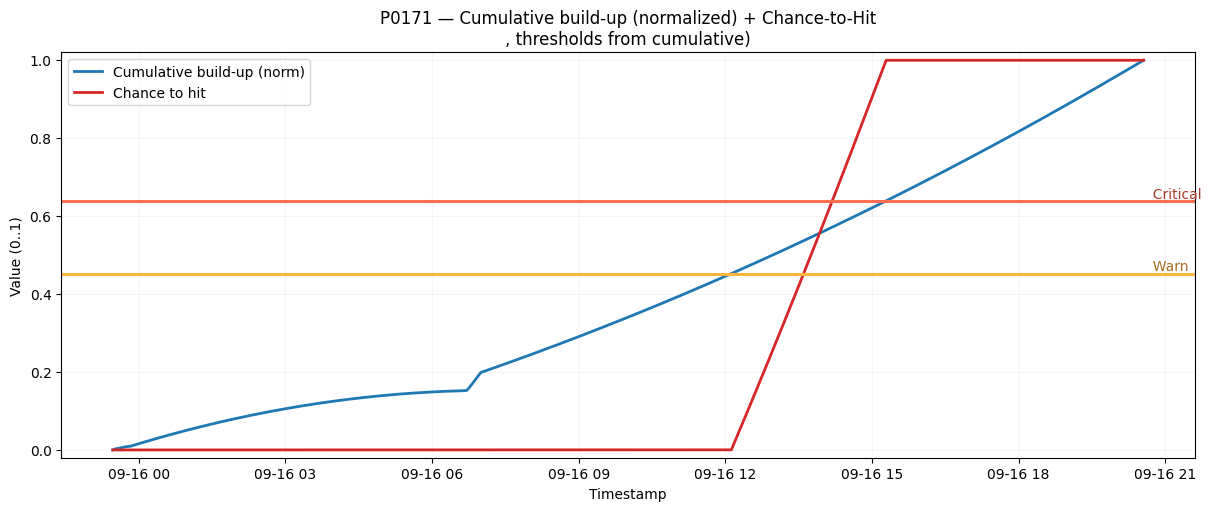

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()



=== Generating plots for P0217 ===


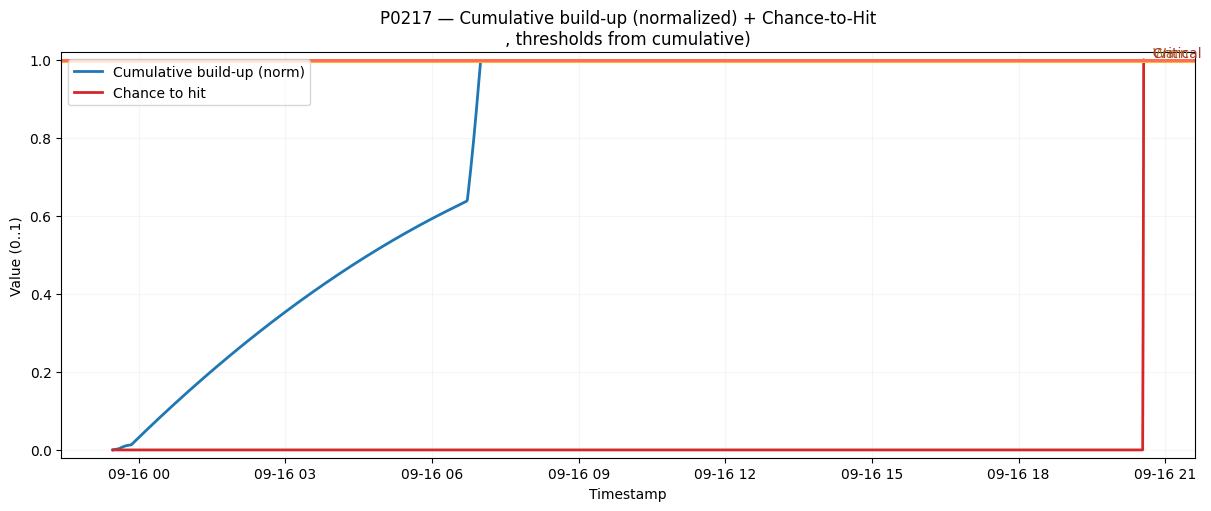

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()



=== Generating plots for P0234 ===


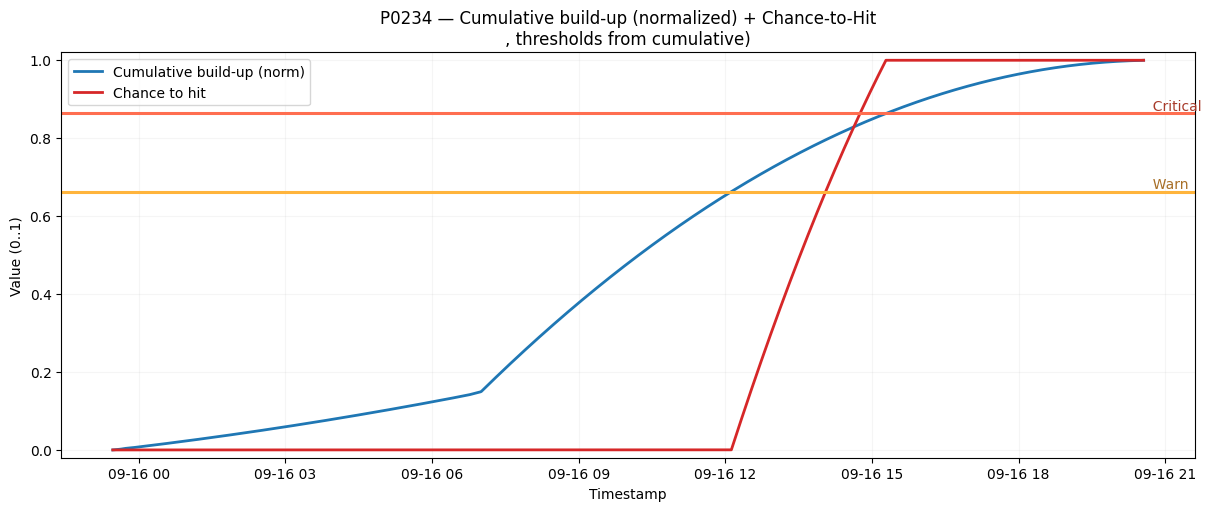


=== Generating plots for P0300 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


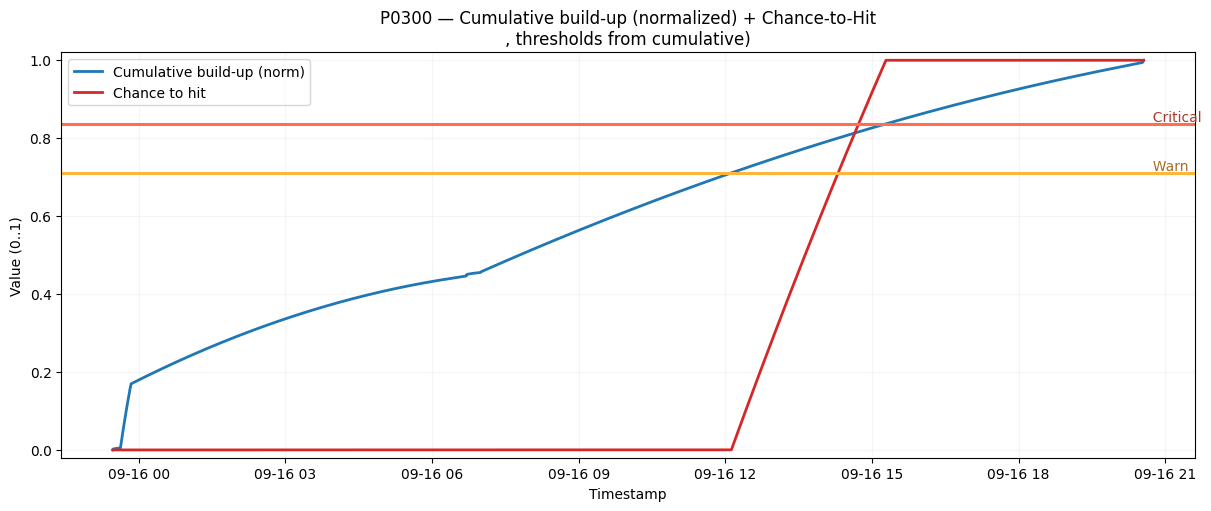


=== Generating plots for P0420 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


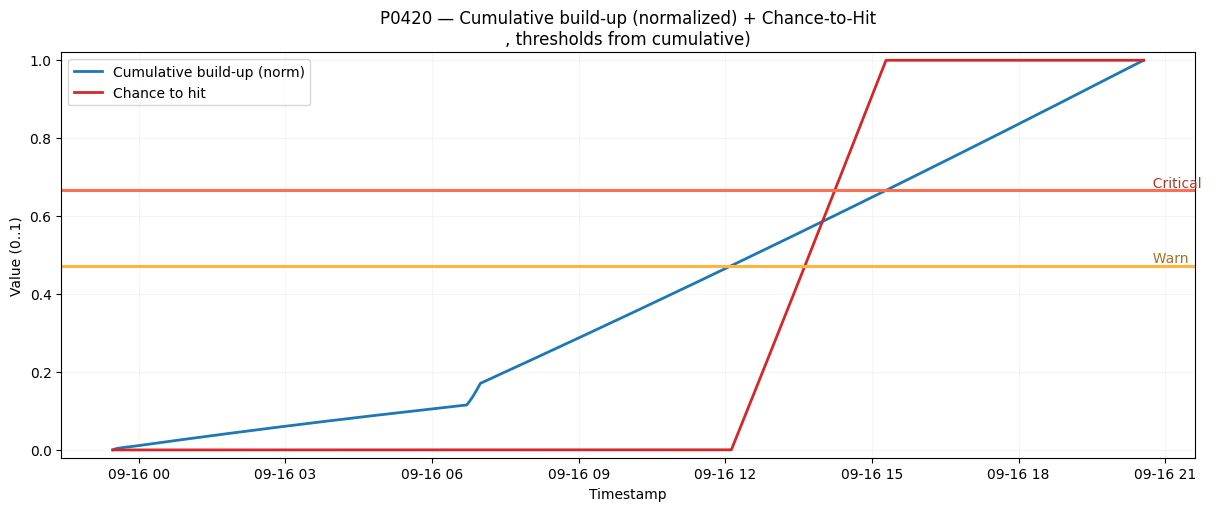


=== Generating plots for P0501 ===


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()


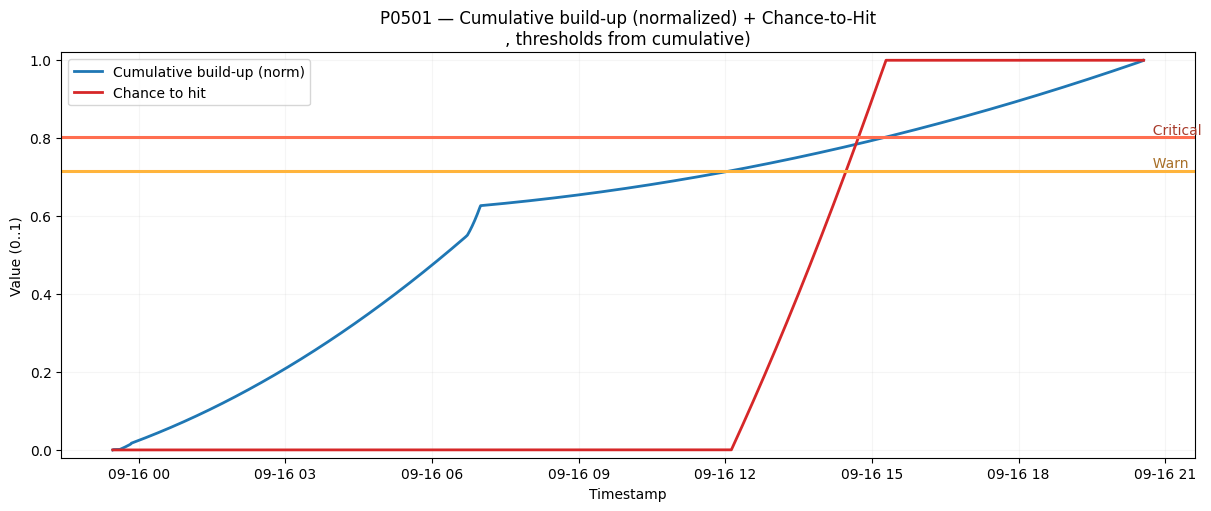

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_25556\224843353.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  ts = ts.resample(freq).mean()



=== Generating plots for P0562 ===


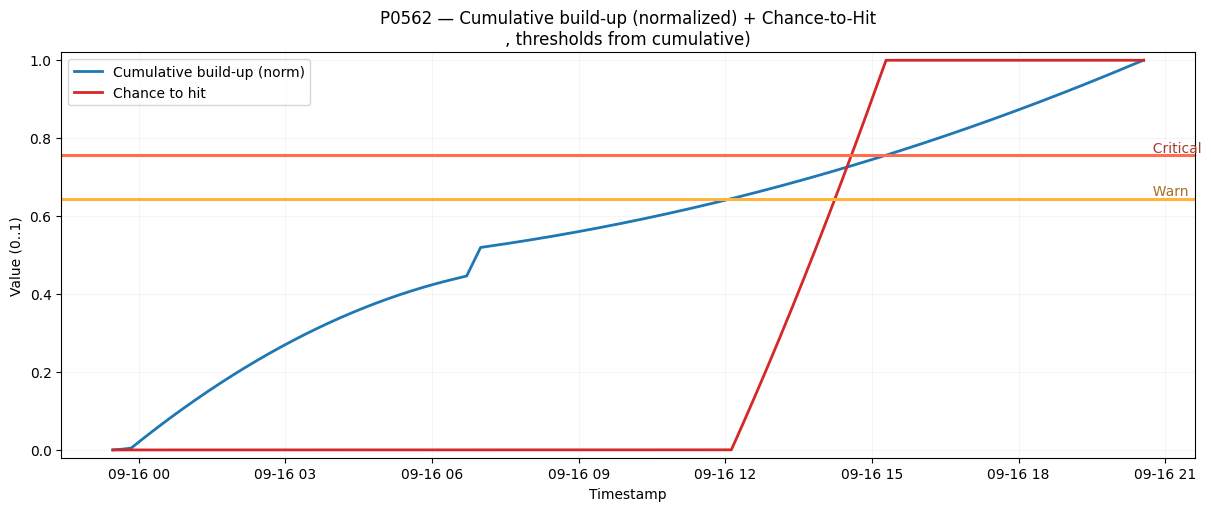

In [3]:
dtc_list = ["P0101", "P0125", "P0133", "P0171", "P0217","P0234", "P0300", "P0420", "P0501", "P0562"]

for dtc in dtc_list:
    print(f"\n=== Generating plots for {dtc} ===")
    try:
        plot_cumulative_build_up_with_chance(
        dtc_code=dtc,
        value_col="p_calib_precursor",   
        resample_freq="1S",
        q_warn=0.60,
        q_crit=0.75,
        figsize=(12,5)
    )
    except Exception as e:
        print(f"[ERROR] {dtc}: {e}")

In [11]:
import webbrowser
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from IPython.display import HTML, display

ROOT = Path(r"C:\engine_module_pipeline")
CSV_DIR = ROOT / r"DTC_stage\data\csv"
PLOTS_DIR = ROOT / r"DTC_stage\plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

COLOR_RISK = "#1f77b4"
COLOR_WARN = "rgba(255,180,60,0.95)"
COLOR_CRIT = "rgba(255,110,80,0.95)"
COLOR_VLINE_WARN = "rgba(255,140,0,0.8)"
COLOR_VLINE_CRIT = "rgba(220,0,0,0.85)"
COLOR_PROB = "#636EFA"
COLOR_CHANCE = "#EF553B"
GRID = "rgba(0,0,0,0.05)"
LINE_W = 2.2

def _load_dtc_csv(dtc_code: str) -> pd.DataFrame:
    path = CSV_DIR / f"{dtc_code}_infer_output.csv"
    if not path.exists():
        raise FileNotFoundError(f"CSV not found at {path}")
    df = pd.read_csv(path, dtype=str)
    print(df.count())
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    for c in df.columns:
        if c not in ["timestamp","date","row_hash","dtc_code","feature_snapshot"]:
            try: df[c] = pd.to_numeric(df[c], errors="coerce")
            except Exception: pass
    return df

def _choose_prob_col(df: pd.DataFrame) -> str:
    prefer = ("p_calib_precursor","p_calib_fault","p_raw_precursor","p_raw_fault")
    for c in prefer:
        if c in df.columns: return c
    pcols = [c for c in df.columns if c.startswith("p_") and pd.api.types.is_numeric_dtype(df[c])]
    if not pcols:
        raise RuntimeError("No probability columns found")
    return pcols[0]

def _resample_interpolate(df: pd.DataFrame, col: str, freq: str="1S") -> pd.DataFrame:
    tmp = df[["timestamp", col]].dropna().sort_values("timestamp")
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce").fillna(0.0).clip(0.0, 1.0)
    ts = tmp.set_index("timestamp")
    if ts.index.has_duplicates:
        ts = ts.groupby(level=0).mean()
    ts = ts.resample(freq).mean()
    ts[col] = ts[col].interpolate(method="time").bfill().ffill().clip(0.0, 1.0)
    return ts.reset_index()

def _ema(series, half_life, freq_s):
    alpha = 1 - np.exp(-np.log(2)*(freq_s/max(1e-6, half_life)))
    return series.ewm(alpha=alpha, adjust=False).mean()

def _savgol(series, win, poly):
    if len(series)<3: return series
    win=max(poly+2,win); win+=1-win%2
    if win>=len(series): win=len(series)-(1-len(series)%2)
    return pd.Series(savgol_filter(series.values, win, poly), index=series.index)

def _compute_risk(df, col, method, hl, win, poly, freq_s):
    p=df[col].clip(0,1)
    if method=="ema": return _ema(p,hl,freq_s).clip(0,1)
    if method=="savgol": return _savgol(p,win,poly).clip(0,1)
    return p

def _derive_thresholds(risk, method="quantile", q_warn=0.8, q_crit=0.95):
    r=risk.dropna().clip(0,1)
    if len(r)==0: return 0.6,0.85
    if method=="robust":
        med=r.median(); mad=(r-med).abs().median()
        warn=np.clip(med+mad,0,1); crit=np.clip(med+2*mad,warn+1e-6,1)
    else:
        warn=float(r.quantile(q_warn)); crit=float(r.quantile(q_crit))
        if crit<=warn: crit=min(1.0,warn+0.05)
    return warn,crit

def _find_warn_crit_cycles(risk, warn, crit):
    warn_ts, crit_ts = [], []
    state = "below"
    for i in range(1, len(risk)):
        prev, curr = risk.iloc[i-1], risk.iloc[i]
        if state=="below" and curr>=warn:
            warn_ts.append(risk.index[i])
            state="warned"
        elif state=="warned" and curr>=crit:
            crit_ts.append(risk.index[i])
            state="crit"
        elif state=="crit" and curr<warn:
            state="below"
    return warn_ts, crit_ts

def _chance_from_risk(risk, warn, crit):
    denom=max(crit-warn,1e-9)
    return ((risk-warn)/denom).clip(0,1)

def _auto_ylim(series, pad=0.05, min_span=0.05):
    s=series.replace([np.inf,-np.inf],np.nan).dropna()
    if s.empty: return (0,1)
    lo,hi=float(s.min()),float(s.max())
    span=hi-lo
    if span<min_span:
        center=0.5*(lo+hi)
        lo,hi=center-min_span/2,center+min_span/2
    lo-=pad*(hi-lo); hi+=pad*(hi-lo)
    lo,hi=max(0,lo),min(1,hi)
    if hi-lo<min_span: hi=min(1,lo+min_span)
    return (lo,hi)

def _save_and_open(fig, slug, show_inline=False, open_in_browser=True):
    ts=datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out=PLOTS_DIR/f"{slug}_{ts}.html"
    fig.write_html(str(out))
    link=out.as_uri()
    print(f"Saved HTML: {out}")
    display(HTML(f'<a href="{link}" target="_blank">Open in browser</a>'))
    if open_in_browser:
        try: webbrowser.open(link,new=2)
        except Exception: pass
    if show_inline: fig.show()
    return str(out)

def plot_two_risk_panels(
    dtc_code,
    value_col=None,
    resample_freq="1S",
    smooth_method="ema",
    ema_half_life_s=60,
    savgol_window_pts=61,
    savgol_poly=3,
    threshold_method="quantile",
    q_warn=0.8,
    q_crit=0.95,
    bottom_panel="prob",
    show_inline=False,
    open_in_browser=True
):
    df=_load_dtc_csv(dtc_code)
    if value_col is None: value_col=_choose_prob_col(df)
    dfr=_resample_interpolate(df,value_col,resample_freq)
    freq_s=pd.to_timedelta(resample_freq).total_seconds()
    dfr["_risk"]=_compute_risk(dfr,value_col,smooth_method,ema_half_life_s,savgol_window_pts,savgol_poly,freq_s)
    warn,crit=_derive_thresholds(dfr["_risk"],threshold_method,q_warn,q_crit)
    warn_i,crit_i=_find_warn_crit_cycles(dfr["_risk"],warn,crit)

    if bottom_panel=="chance":
        dfr["_chance"]=_chance_from_risk(dfr["_risk"],warn,crit)
        bottom_y=dfr["_chance"]; bottom_color=COLOR_CHANCE; bottom_name="chance to hit"
    else:
        bottom_y=dfr[value_col].clip(0,1); bottom_color=COLOR_PROB; bottom_name=value_col

    y1_lo,y1_hi=_auto_ylim(dfr["_risk"],pad=0.05,min_span=0.05)
    y1_lo=min(y1_lo,warn*0.95); y1_hi=max(y1_hi,crit*1.05)
    y2_lo,y2_hi=_auto_ylim(bottom_y,pad=0.1,min_span=0.1)

    fig=make_subplots(rows=2,cols=1,shared_xaxes=True,vertical_spacing=0.1)

    fig.add_trace(go.Scatter(x=dfr["timestamp"],y=dfr["_risk"],mode="lines",
                             name=f"risk ({smooth_method})",
                             line=dict(width=LINE_W,color=COLOR_RISK)),row=1,col=1)
    fig.add_hline(y=warn,line=dict(color=COLOR_WARN,width=2.4),row=1,col=1)
    fig.add_hline(y=crit,line=dict(color=COLOR_CRIT,width=2.4),row=1,col=1)

    for idx in warn_i:
        ts=dfr["timestamp"].iloc[idx]
        fig.add_vline(x=ts,line=dict(color=COLOR_VLINE_WARN,width=1.8,dash="dot"),row=1,col=1)
    for idx in crit_i:
        ts=dfr["timestamp"].iloc[idx]
        fig.add_vline(x=ts,line=dict(color=COLOR_VLINE_CRIT,width=1.8,dash="dot"),row=1,col=1)

    fig.add_trace(go.Scatter(x=dfr["timestamp"],y=bottom_y,mode="lines",
                             name=bottom_name,
                             line=dict(width=LINE_W,color=bottom_color)),row=2,col=1)

    fig.update_yaxes(title_text="risk",range=[y1_lo,y1_hi],showgrid=True,gridcolor=GRID,row=1,col=1)
    fig.update_yaxes(title_text=("chance" if bottom_panel=="chance" else "probability"),
                     range=[y2_lo,y2_hi],showgrid=True,gridcolor=GRID,row=2,col=1)
    fig.update_xaxes(showgrid=True,gridcolor=GRID,row=1,col=1)
    fig.update_xaxes(showgrid=True,gridcolor=GRID,row=2,col=1)

    fig.update_layout(
        title=f"{dtc_code} — risk ({smooth_method}, resampled {resample_freq}) — all warn/crit cycles",
        template="simple_white",
        legend=dict(orientation="h",y=1.12,x=0.5,xanchor="center",yanchor="bottom",font=dict(size=11)),
        margin=dict(l=72,r=60,t=110,b=64),
        hovermode="x unified",
        height=760,
        width=1200
    )

    _save_and_open(fig,f"{dtc_code}_risk2panels_cycles",show_inline,open_in_browser)

# plot_two_risk_panels(
#     "P0101",
#     value_col="p_calib_precursor",
#     resample_freq="1S",
#     smooth_method="ema",  # or 'savgol'
#     ema_half_life_s=60,
#     threshold_method="quantile", q_warn=0.80, q_crit=0.95,
#     bottom_panel="prob",  # or "chance"
#     show_inline=False,
#     open_in_browser=True
# )


In [12]:
dtc_list = ["P0234", "P0300", "P0420", "P0501", "P0562"]

for dtc in dtc_list:
    print(f"\n=== Generating plots for {dtc} ===")
    try:
        plot_two_risk_panels(
            dtc_code=dtc,
            value_col="p_calib_precursor",   
            resample_freq="1S",
            smooth_method="ema",              # or "savgol"
            ema_half_life_s=60,
            threshold_method="quantile", q_warn=0.80, q_crit=0.95,
            bottom_panel="chance",            # can switch to "chance"
            show_inline=False,
            open_in_browser=True 	
        )

        plot_two_risk_panels(
            dtc_code=dtc,
            value_col="p_calib_precursor",   
            resample_freq="1S",
            smooth_method="savgol",              # or "savgol"
            ema_half_life_s=60,
            threshold_method="quantile", q_warn=0.80, q_crit=0.95,
            bottom_panel="chance",              # can switch to "chance"
            show_inline=False,
            open_in_browser=True 
        )
    except Exception as e:
        print(f"[ERROR] {dtc}: {e}")



=== Generating plots for P0234 ===
row_hash             1953
timestamp            1953
date                 1953
dtc_code             1953
p_raw_precursor      1953
p_calib_precursor    1953
p_raw_fault          1953
p_calib_fault        1953
dPdt_precursor       1953
dPdt_fault           1953
pred_precursor_on    1953
pred_fault_on        1953
alert_level          1953
feature_snapshot     1953
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0234_risk2panels_cycles_20251024_202035.html


row_hash             1953
timestamp            1953
date                 1953
dtc_code             1953
p_raw_precursor      1953
p_calib_precursor    1953
p_raw_fault          1953
p_calib_fault        1953
dPdt_precursor       1953
dPdt_fault           1953
pred_precursor_on    1953
pred_fault_on        1953
alert_level          1953
feature_snapshot     1953
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0234_risk2panels_cycles_20251024_202036.html



=== Generating plots for P0300 ===
row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0300_risk2panels_cycles_20251024_202037.html


row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0300_risk2panels_cycles_20251024_202038.html



=== Generating plots for P0420 ===
row_hash             1873
timestamp            1873
date                 1873
dtc_code             1873
p_raw_precursor      1873
p_calib_precursor    1873
p_raw_fault          1873
p_calib_fault        1873
dPdt_precursor       1873
dPdt_fault           1873
pred_precursor_on    1873
pred_fault_on        1873
alert_level          1873
feature_snapshot     1873
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0420_risk2panels_cycles_20251024_202039.html


row_hash             1873
timestamp            1873
date                 1873
dtc_code             1873
p_raw_precursor      1873
p_calib_precursor    1873
p_raw_fault          1873
p_calib_fault        1873
dPdt_precursor       1873
dPdt_fault           1873
pred_precursor_on    1873
pred_fault_on        1873
alert_level          1873
feature_snapshot     1873
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0420_risk2panels_cycles_20251024_202040.html



=== Generating plots for P0501 ===
row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0501_risk2panels_cycles_20251024_202041.html


row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0501_risk2panels_cycles_20251024_202042.html



=== Generating plots for P0562 ===
row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0562_risk2panels_cycles_20251024_202043.html


row_hash             1937
timestamp            1937
date                 1937
dtc_code             1937
p_raw_precursor      1937
p_calib_precursor    1937
p_raw_fault          1937
p_calib_fault        1937
dPdt_precursor       1937
dPdt_fault           1937
pred_precursor_on    1937
pred_fault_on        1937
alert_level          1937
feature_snapshot     1937
dtype: int64


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:55: FutureWarning:

'S' is deprecated and will be removed in a future version, please use 's' instead.

C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_14000\960961000.py:149: FutureWarning:

'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.



Saved HTML: C:\engine_module_pipeline\DTC_stage\plots\P0562_risk2panels_cycles_20251024_202044.html
